<a href="https://colab.research.google.com/github/javierespinozat/kaggle-competitions/blob/master/Digit_Recognizer_Learn_computer_vision_fundamentals_with_the_famous_MNIST_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Competition Description**



>   In this competition, your goal is to correctly identify digits from a dataset of tens of thousands of handwritten images. We’ve curated a set of tutorial-style kernels which cover everything from regression to neural networks. We encourage you to experiment with different algorithms to learn first-hand what works well and how techniques compare.

**Goal**


> The goal in this competition is to take an image of a handwritten single digit, and determine what that digit is.
For every in the test set, you should predict the correct label.


**Metric**


> This competition is evaluated on the categorization accuracy of your predictions (the percentage of images you get correct).


**Submission File Format**
> The file should contain a header and have the following format:



```
ImageId,Label
1,0
2,0
3,0
etc.
```








Acknowledgements 
More details about the dataset, including algorithms that have been tried on it and their levels of success, can be found at http://yann.lecun.com/exdb/mnist/index.html. The dataset is made available under a Creative Commons Attribution-Share Alike 3.0 license.

In [0]:
#set up kaggle.com API
from google.colab import files
files.upload()

!pip install -q kaggle==1.5.4

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

!kaggle competitions download -c digit-recognizer

Saving kaggle.json to kaggle.json
     |████████████████████████████████| 61kB 9.2MB/s 
kaggle.json
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 112MB/s]
 55% 5.00M/9.16M [00:01<00:01, 2.90MB/s]
100% 9.16M/9.16M [00:01<00:00, 5.29MB/s]
 82% 5.00M/6.09M [00:00<00:00, 6.14MB/s]
100% 6.09M/6.09M [00:00<00:00, 7.45MB/s]


In [0]:
!unzip test.csv.zip
!unzip train.csv.zip

Archive:  test.csv.zip
  inflating: test.csv                
Archive:  train.csv.zip
  inflating: train.csv               


In [0]:
!head -5 train.csv

label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119,pixel120,pixel121,pixel1

In [0]:
!cat train.csv | wc -l

42001


In [0]:
%tensorflow_version 2.x
import pandas as pd
import numpy as np

!pip install -q keras==2.3.0
import keras
from keras import regularizers
from keras import optimizers
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.regularizers import l1, l2
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

!pip install -q livelossplot
from livelossplot import PlotLossesKeras

from time import time
import matplotlib.pyplot as plt
%matplotlib inline

TensorFlow 2.x selected.
     |████████████████████████████████| 378kB 20.5MB/s 


Using TensorFlow backend.


In [0]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
df_train = pd.read_csv('train.csv', sep =',')
display(df_train.columns)
df_train.head()

Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
for i in df_train.columns:
  if df_train[i].isna().any() == True:
    print('in {} is a null'.format(i))
else: print('all ok')

all ok


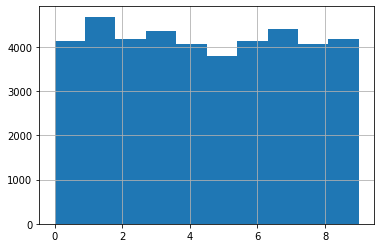

In [0]:
df_train['label'].hist()

In [0]:
#split data
train_x = df_train.sample(frac=0.79, random_state=1)
test_x = df_train.drop(train_x.index)

#pop targets
train_y = to_categorical(train_x.pop('label'))
test_y = to_categorical(test_x.pop('label'))

train_x = train_x/255
test_x = test_x/255

train_x = train_x.values.reshape(-1,28,28,1) #-1 means we want numpy to figure out one dimension one channel for grayscale
test_x = test_x.values.reshape(-1,28,28,1)



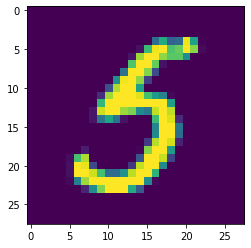

In [0]:
plt.imshow(train_x[1][:,:,0])

In [0]:
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((33180, 28, 28, 1), (8820, 28, 28, 1), (33180, 10), (8820, 10))

In [0]:
datagen = keras.preprocessing.image.ImageDataGenerator(featurewise_center=True, 
                                                       samplewise_center=False, 
                                                       featurewise_std_normalization=False, 
                                                       samplewise_std_normalization=False, 
                                                       zca_whitening=False, 
                                                       zca_epsilon=1e-06, 
                                                       rotation_range=10, 
                                                       width_shift_range=0.1, 
                                                       height_shift_range=0.1, 
                                                      # brightness_range=[0.9, 1.1], 
                                                      # shear_range=0.1, 
                                                       zoom_range=0.1, 
                                                       #channel_shift_range=0.0, 
                                                       fill_mode='nearest', 
                                                       cval=0.0, 
                                                       horizontal_flip=False,
                                                       vertical_flip=False, #no upside down since 9 and 6 ...
                                                       rescale=None, 
                                                       preprocessing_function=None, 
                                                       data_format='channels_last', 
                                                       validation_split=0.20, 
                                                       interpolation_order=1, 
                                                       dtype='float32')

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(train_x)

In [0]:
def model_v3():
  
  model = keras.models.Sequential()
 
  model.add(keras.layers.Conv2D(filters = 64, kernel_size = (5,5), strides = (1, 1), padding = 'same', input_shape = train_x.shape[1:4], 
                                data_format= 'channels_last', dilation_rate = (1,1), activation='relu', use_bias=True, 
                                kernel_initializer='TruncatedNormal', bias_initializer='TruncatedNormal', kernel_regularizer= None, 
                                bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)) 
  model.add(MaxPool2D(pool_size=(2, 2), strides=None, padding='same', data_format=None))
  model.add(Dropout(0.2))

  model.add(keras.layers.Conv2D(filters = 64, kernel_size = (4,4), strides = (1,1), padding = 'same', input_shape = train_x.shape[1:4], 
                                data_format= 'channels_last', dilation_rate = (1,1), activation='relu', use_bias=True, 
                                kernel_initializer='TruncatedNormal', bias_initializer='TruncatedNormal', kernel_regularizer= None, 
                                bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)) 
  model.add(MaxPool2D(pool_size=(2, 2), strides=None, padding='same', data_format=None))
  model.add(Dropout(0.2))

  model.add(keras.layers.Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'same', input_shape = train_x.shape[1:4], 
                                data_format= 'channels_last', dilation_rate = (1,1), activation='relu', use_bias=True, 
                                kernel_initializer='TruncatedNormal', bias_initializer='TruncatedNormal', kernel_regularizer= None, 
                                bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)) 
  model.add(MaxPool2D(pool_size=(2, 2), strides=None, padding='same', data_format=None))
  model.add(Dropout(0.2))
  
  #FLATTEN
  model.add(Flatten())

  model.add(Dense(1000, kernel_initializer = 'TruncatedNormal', use_bias= True, bias_initializer='TruncatedNormal', activation='relu', 
                  activity_regularizer = regularizers.l1(5*10**(-5))))
  model.add(Dropout(0.5))

  model.add(Dense(500, kernel_initializer = 'TruncatedNormal', use_bias= True, bias_initializer='TruncatedNormal', activation='relu', 
                  kernel_regularizer = None))

  #output-softmax
  model.add(Dense(train_y.shape[1], activation='softmax'))

 #compile
  model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

  return model

model_v3 = model_v3()

model_v3.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 28, 28, 64)        1664      
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 14, 14, 64)        65600     
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 7, 7, 64)        

In [0]:
start = time()
#es = keras.callbacks.callbacks.EarlyStopping(monitor='val_accuracy', verbose=1, mode='min', baseline=0.995, restore_best_weights=False)

history_v3 = model_v3.fit_generator(datagen.flow(train_x, train_y, batch_size =32, subset = 'training'), 
                                    steps_per_epoch = len(train_x)//32, 
                                    epochs = 70, verbose=0, callbacks= [PlotLossesKeras()], 
                                    validation_data=datagen.flow(train_x, train_y, batch_size =32, subset='validation'), 
                                    validation_steps = len(train_x)*0.2//32, 
                                    validation_freq=1, 
                                    class_weight=None, 
                                    max_queue_size=10, 
                                    workers=1, 
                                    use_multiprocessing=False, 
                                    shuffle=False,
                                    initial_epoch=0)

score_v3 = model_v3.evaluate(x = test_x, y = test_y, batch_size=32, verbose=1, sample_weight=None, steps=None, callbacks=None, max_queue_size=10, workers=12, use_multiprocessing=False)
print('\n score: {} \n'.format(dict(zip(model_v3.metrics_names, score_v3))))

print('\n run time:', (time()-start)//60, 'minutes' )

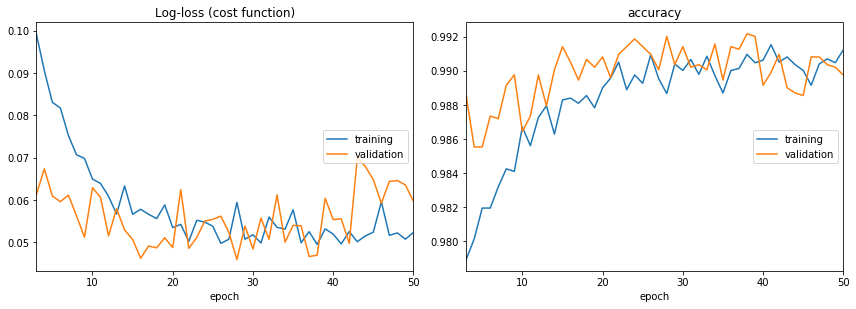

Log-loss (cost function):
training   (min:    0.050, max:    0.374, cur:    0.052)
validation (min:    0.046, max:    0.119, cur:    0.060)

accuracy:
training   (min:    0.901, max:    0.992, cur:    0.991)
validation (min:    0.974, max:    0.992, cur:    0.990)
8820/8820 [==============================] - 1s 78us/step

 score: {'loss': 0.05740636081652306, 'accuracy': 0.9905895590782166} 


 run time: 5.0 minutes


In [0]:
start = time()
history_v3 =  model_v3.fit(train_x, train_y.astype('int'), 
                           epochs=50, shuffle = True, 
                           validation_split = 0.2, 
                           workers=1, 
                           callbacks=[PlotLossesKeras()], verbose=0)

score_v3 = model_v3.evaluate(x = test_x, y = test_y, batch_size=32, verbose=1, sample_weight=None, steps=None, callbacks=None, max_queue_size=10, workers=12, use_multiprocessing=False)
print('\n score: {} \n'.format(dict(zip(model_v3.metrics_names, score_v3))))
print('\n run time:', (time()-start)//60, 'minutes' )

#test

In [0]:
x_test = pd.read_csv('test.csv')
x_test = x_test/255


In [0]:
x_test = x_test.values.reshape(-1,28,28,1) #-1 means we want numpy to figure out one dimension


In [0]:
prediction_v3 = model_v3.predict(x_test)

In [0]:
prediction_v3

array([[3.4681350e-17, 7.9732998e-17, 1.0000000e+00, ..., 4.7019780e-11,
        1.4920091e-11, 1.2458216e-15],
       [1.0000000e+00, 7.7892877e-23, 2.0056402e-18, ..., 2.4811885e-14,
        1.4467718e-12, 7.9547612e-11],
       [1.7496013e-21, 1.7980156e-18, 1.2927676e-17, ..., 9.4911932e-11,
        5.4187144e-09, 1.0000000e+00],
       ...,
       [9.1416534e-22, 7.3311271e-17, 1.6788032e-16, ..., 9.7681686e-15,
        3.4638533e-12, 7.5007837e-14],
       [3.3288153e-10, 6.6469880e-10, 1.3064590e-08, ..., 1.4184421e-05,
        1.2217291e-05, 9.9941278e-01],
       [2.5875035e-18, 4.1056473e-18, 1.0000000e+00, ..., 1.8707957e-11,
        1.6284692e-11, 4.6680097e-16]], dtype=float32)

In [0]:
submission_v3 = np.argmax(prediction_v3, axis = -1)
submission_v3

array([2, 0, 9, ..., 3, 9, 2])

In [0]:
len(submission_v3)

28000

In [0]:
type(submission_v3)

numpy.ndarray

In [0]:
submission_v3 = pd.DataFrame(submission_v3, columns = ['Label'])
submission_v3.head()

,Label
0,2
1,0
2,9
3,0
4,3


In [0]:
submission_v3['ImageId'] = np.arange(1,len(submission_v3)+1,1)

submission_v3.head()

,Label,ImageId
0,2,1
1,0,2
2,9,3
3,0,4
4,3,5


In [0]:
submission_v3.to_csv("submission_v3_15.csv", index=False, header=True)

In [0]:
!kaggle competitions submit digit-recognizer -f submission_v3_15.csv -m "CNN"

100% 208k/208k [00:11<00:00, 18.8kB/s]
Successfully submitted to Digit Recognizer

infography

* <3 TensorFlow and Deep Learning without a PhD, Part 1 (Google Cloud Next '17)
  https://www.youtube.com/watch?v=u4alGiomYP4

* padding https://deeplizard.com/learn/video/qSTv_m-KFk0

*imagedatagenerator arguments
https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/

* dilation v/s stride https://www.quora.com/What-is-the-difference-between-dilated-convolution-and-convolution+stride

* general 2dconvolutional intro https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6

* regularizers
https://keras.io/regularizers/

* wight initializers https://towardsdatascience.com/hyper-parameters-in-action-part-ii-weight-initializers-35aee1a28404
